# <center>Experiment 1.2</center>

### <center>Improvement 1: Double DQN</center>

In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from typing import Sequence
from collections import namedtuple, deque
import itertools
import random
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Hyperparameters
GAMMA = 0.99
BATCH_SIZE = 64
BUFFER_SIZE = 10000
MIN_REPLAY_SIZE = 5000
EPS_START = 1.0
EPS_END = 0.05
EPS_DECAY = 0.997
TARGET_UPDATE_FREQ = 5

In [3]:
# Create LunarLander environment
env = gym.make("LunarLander-v2", render_mode = "rgb_array")
obs, _ = env.reset()
episode_reward = 0.0

In [4]:
# Define the Transition named tuple
Transition = namedtuple('Transition', ('states', 'actions', 'rewards', 'dones', 'next_states'))

# Define Replay Memory class
class Replay_memory():

    def __init__(self, env, fullsize, minsize, batchsize):
        self.env = env
        self.memory = deque(maxlen=fullsize)
        self.rewards = deque(maxlen=50)
        self.batchsize = batchsize
        self.minsize = minsize

    def append(self, transition):
        self.memory.append(transition)

    def sample_batch(self):
        # Sample a batch of transitions from memory
        batch = random.sample(self.memory, self.batchsize)
        batch = Transition(*zip(*batch))
        states = torch.from_numpy(np.array(batch.states, dtype=np.float32))
        actions = torch.from_numpy(np.array(batch.actions, dtype=np.int64)).unsqueeze(1)
        rewards = torch.from_numpy(np.array(batch.rewards, dtype=np.float32)).unsqueeze(1)
        dones = torch.from_numpy(np.array(batch.dones, dtype=np.bool8)).unsqueeze(1)
        next_states = torch.from_numpy(np.array(batch.next_states, dtype=np.float32))
        return states, actions, rewards, dones, next_states

    def initialize(self):
        # Initialize replay memory with random actions
        obs, _ = env.reset()
        for _ in range(self.minsize):
            action = self.env.action_space.sample()
            new_obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            transition = Transition(obs, action, reward, done, new_obs)
            self.append(transition)
            obs = new_obs
            if done:
                self.env.reset()
        return self

In [5]:
# Initialize replay memory
replay_memory = Replay_memory(env, BUFFER_SIZE, MIN_REPLAY_SIZE, BATCH_SIZE).initialize()

In [6]:
# Define Deep Q Network (DQN) class
class DQN(nn.Module):
    def __init__(self, ninputs, noutputs):
        super(DQN, self).__init__()
        self.a1 = nn.Linear(ninputs, 64)
        self.a2 = nn.Linear(64, noutputs)

    def forward(self, X):
        # Forward pass through the network
        o = self.a1(X)
        o = torch.tanh(o)
        o = self.a2(o)
        return o

    def __call__(self, X):
        return self.forward(X)

In [7]:
# Create DQN policy and target networks
dqn_policy = DQN(env.observation_space.shape[0], env.action_space.n)
dqn_target = DQN(env.observation_space.shape[0], env.action_space.n)
dqn_target.load_state_dict(dqn_policy.state_dict())
dqn_target.eval()

DQN(
  (a1): Linear(in_features=8, out_features=64, bias=True)
  (a2): Linear(in_features=64, out_features=4, bias=True)
)

In [8]:
# Define loss function, learning rate, and optimizer
loss_fn = nn.MSELoss()
learning_rate = 0.0005
optimizer = torch.optim.Adam(dqn_policy.parameters(), lr=learning_rate)

In [9]:
# Define epsilon-greedy policy
def epsilon_greedy_policy(epsilon, obs):
    rnd_sample = random.random()
    if rnd_sample <= epsilon:
        action = env.action_space.sample()
    else:
        with torch.no_grad():
            action = int(torch.argmax(dqn_policy(torch.Tensor(obs))))
    return action

## Training

In [10]:
# Reset environment and initialize variables
obs, _ = env.reset()
eps_threshold =EPS_START
episode = 1
all_rewards = []
all_episodes = []

# Main training loop
for step in itertools.count():
    # Choose action using epsilon-greedy policy
    action = epsilon_greedy_policy(eps_threshold, obs)
    
    # Take action and observe new state, reward, and termination status
    new_obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    
    # Store transition in replay memory
    replay_memory.append(Transition(obs, action, reward, done, new_obs))
    episode_reward += reward
    obs = new_obs

    # If episode is done, update epsilon, reset environment, and log statistics
    if done:
        episode += 1
        eps_threshold = np.max((eps_threshold*EPS_DECAY, EPS_END))
        replay_memory.rewards.append(episode_reward)
        obs, _ = env.reset()
        avg_res = np.mean(replay_memory.rewards)
        
        all_rewards.append(avg_res)
        all_episodes.append(episode)
        
        # Print statistics every 100 episodes
        if episode % 100 == 0:
            print(f'Episode: {episode} Avg Results: {avg_res} Epsilon: {eps_threshold}')

        # Check if the environment is considered solved
        if avg_res >= 195:
            print(f'Solved at episode: {episode} Avg Results: {avg_res}')
            break
        episode_reward = 0

    # Sample a batch from replay memory
    b_states, b_actions, b_rewards, b_dones, b_next_states = replay_memory.sample_batch()

    # Compute Q-values and target Q-values
    qvalues = dqn_policy(b_states).gather(1, b_actions)

    with torch.no_grad():
        # use dqn_policy to get actions in next state
        _, next_actions = dqn_policy(b_next_states).max(dim=1, keepdim=True)
        
        # use dqn_target to get values of actions selected by dqn_policy
        next_action_values = dqn_target(b_next_states).gather(1, next_actions)  

        # Compute expected Q-values
        expected_qvalues = b_rewards + GAMMA * (1 - b_dones.type(torch.int64)) * next_action_values

     # Compute and backpropagate loss
    loss = loss_fn(qvalues, expected_qvalues)
    optimizer.zero_grad()
    loss.backward()
    
    # Clip gradients to prevent exploding gradients
    for param in dqn_policy.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

    # Update target network every TARGET_UPDATE_FREQ episodes
    if episode % TARGET_UPDATE_FREQ == 0:
        dqn_target.load_state_dict(dqn_policy.state_dict())


Episode: 100 Avg Results: -182.6131515307786 Epsilon: 0.7427123967299725
Episode: 200 Avg Results: -134.72222670785874 Epsilon: 0.549966839143611
Episode: 300 Avg Results: -87.92931699823605 Epsilon: 0.40724178765469166
Episode: 400 Avg Results: 60.4683796197658 Epsilon: 0.3015561335851415
Episode: 500 Avg Results: 114.7022335073315 Epsilon: 0.22329757028747313
Episode: 600 Avg Results: 166.37837120134995 Epsilon: 0.16534833599135207
Solved at episode: 641 Avg Results: 195.37330173008374


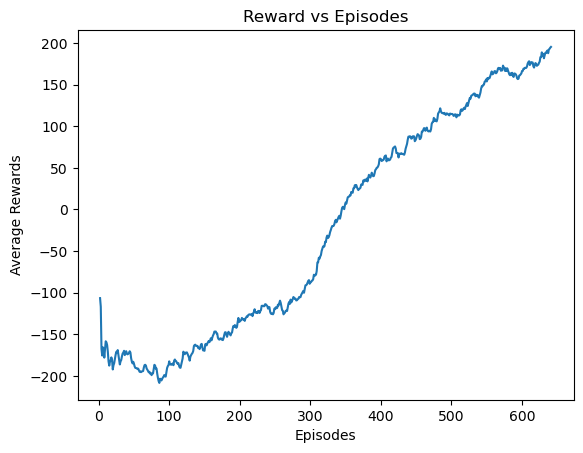

In [11]:
# Plot the returns versus trained episodes
plt.plot(all_episodes, all_rewards)
plt.xlabel('Episodes')
plt.ylabel('Average Rewards')
plt.title('Reward vs Episodes')
plt.show()